# Sustainability scores processing

BC3 provides access to static results (Colombia at 1km resolution) for a sustainability score per each of the four dimensions (see mor info [here](https://drive.google.com/file/d/1wh0QTN89Zs8Cpsh32mgiTMYA5-yKPykB/view?usp=sharing)). Particularly useful for Vizzuality to build their side of the MVP, while access to k.LAB via API is a work in progress:

[Data source](https://drive.google.com/drive/folders/19I7d9xDHxZtRHW9tG166JhWeoagbVdBD?usp=sharing)

## Purpose

The purpose of this notebooks is to vectorized the 4 dimensions scores into three different scales:
- Municipalities ([data source](https://basecamp.com/1756858/projects/18107300/messages/99371742?enlarge=452957920#attachment_452957920))
- HeCo Mosaics ([data source](https://basecamp.com/1756858/projects/18107300/messages/99371742?enlarge=450698651#attachment_450698651))
- Hydrological basins ([data source](https://data.apps.fao.org/aquamaps/))


## Setup

### Library import

We import all the required Python libraries

In [10]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import regionmask
import cartopy.crs as ccrs
from shapely.geometry import MultiPolygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Utils

**create_ds_mask**

In [183]:
def set_lat_lon_attrs(ds, lon_name='lon', lat_name='lat'):
    """ Set CF latitude and longitude attributes"""
    ds[lon_name] = ds[lon_name].assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds[lat_name] = ds[lat_name].assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    """Create masks of geographical regions"""
    # Create index column
    if 'index' not in df:
        df = df.reset_index(drop=True).reset_index()

    # Extract indexes and geoms that are large enough!
    id_ints = df['index'].values
    geoms = df['geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')


    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # get the ints not written to mask
    id_ints_not_in_mask = df[~df['index'].isin(id_ints_mask)]['index'].values
    
    if len(id_ints_not_in_mask) > 0: 
        print(f'Ints not in mask: {id_ints_not_in_mask}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask, lon_name, lat_name)
    
    return da_mask, id_ints_not_in_mask

# Data import
We retrieve all the data required for the analysis.
## Raster data
### Sustainability scores
**Read data**

In [11]:
dir_path = '../../datasets/raw/sustainability_scores'
file_dict = {'biodiversity': 'Biodiversity.tiff',
'climate': 'Climate.tiff',
'community': 'Community.tiff',
'water': 'Water.tiff'}

for key, value in file_dict.items():
    ds_tmp = xr.open_dataset(f'{dir_path}/{value}').squeeze().drop("band").rename({'band_data': key})
    if key == 'biodiversity':
        ds = ds_tmp
    else:
        ds[key] = ds_tmp[key]

ds

<xarray.Dataset>
Dimensions:       (x: 1348, y: 1846)
Coordinates:
  * x             (x) float64 -79.01 -79.0 -78.99 ... -66.89 -66.88 -66.87
  * y             (y) float64 12.45 12.44 12.44 12.43 ... -4.206 -4.215 -4.224
    spatial_ref   int64 ...
Data variables:
    biodiversity  (y, x) float32 ...
    climate       (y, x) float32 ...
    community     (y, x) float32 ...
    water         (y, x) float32 ...

**Display data**

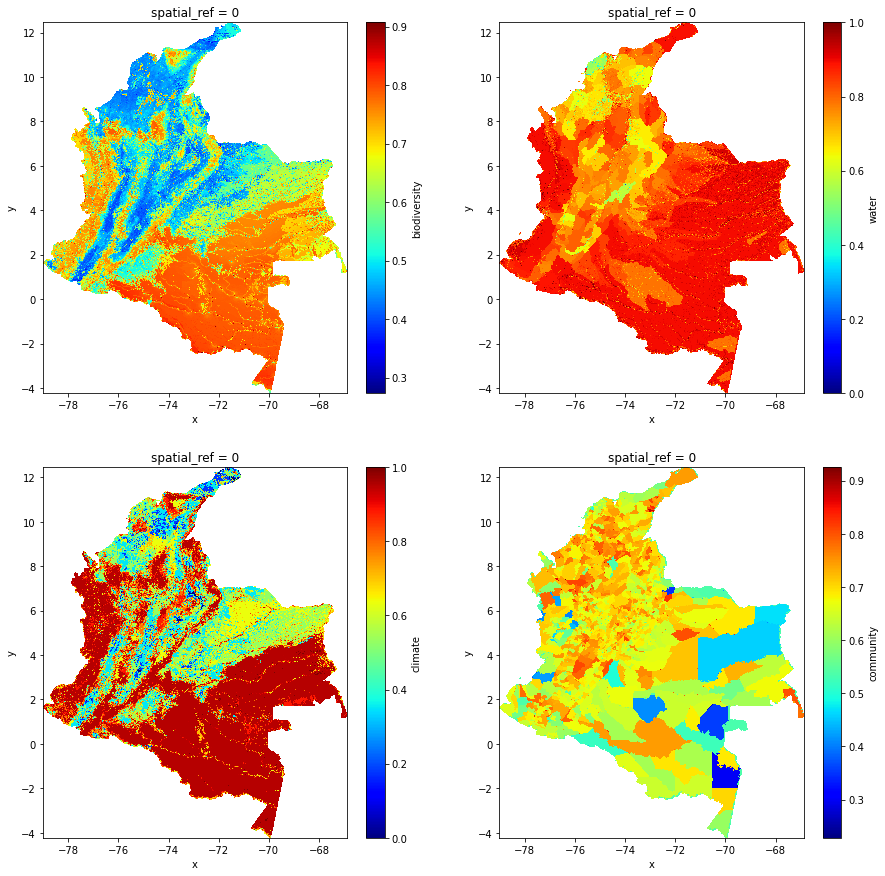

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))

ds['biodiversity'].plot(ax=ax[0,0], cmap='jet')
ds['climate'].plot(ax=ax[1,0], cmap='jet')
ds['water'].plot(ax=ax[0,1], cmap='jet')
ds['community'].plot(ax=ax[1,1], cmap='jet')

## Vector data 
### Municipalities
**Read data**

In [41]:
municipalities = gpd.read_file(f'../../datasets/raw/Limites Políticos Colombia/Limite_Municipal.shp')

Change projection

In [43]:
municipalities.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [44]:
municipalities = municipalities.to_crs("EPSG:4326")
municipalities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Remove San Andrés, and Providencia

In [45]:
municipalities = municipalities[~municipalities['DEPARTAMEN'].isin(['SAN ANDRÉS PROVIDENCIA Y SANTA CATALINA'])]
municipalities = municipalities.reset_index(drop=True)
municipalities.head(1)

,NOMBRE_ENT,CATEGORIA,DEPARTAMEN,COD_DEPART,COD_MUNICI,AREA_KM,OBSERVACIO,PK_CUE,ACTO_ADMIN,SHAPE_Leng,SHAPE_Area,geometry
0,POTOSÍ,M,NARIÑO,52,560,376.602234,None,501281.0,None,1.258261,0.030493,"POLYGON ((-77.18681 0.63095, -77.37836 0.63707..."


Remove duplicates

In [46]:
duplicates = list(municipalities[municipalities.duplicated(subset=['NOMBRE_ENT', 'DEPARTAMEN'])]['NOMBRE_ENT'].unique())
print(duplicates)

['PANÁ-PANÁ (Campo Alegre)', 'TUMACO']


In [47]:
pana = municipalities[municipalities['NOMBRE_ENT'] == duplicates[0]].iloc[:1]
pana

,NOMBRE_ENT,CATEGORIA,DEPARTAMEN,COD_DEPART,COD_MUNICI,AREA_KM,OBSERVACIO,PK_CUE,ACTO_ADMIN,SHAPE_Leng,SHAPE_Area,geometry
455,PANÁ-PANÁ (Campo Alegre),CD,GUAINÍA,94,887,10196.363739,En proceso de Aprobación. Sujeto a cambios,500771.0,None,7.823319,0.825044,"POLYGON ((-68.77132 2.42182, -68.77097 2.42088..."


In [48]:
tumaco = municipalities[municipalities['NOMBRE_ENT'] == duplicates[1]].reset_index(drop=True)
tumaco.at[0, 'geometry'] = MultiPolygon([tumaco['geometry'].iloc[0], tumaco['geometry'].iloc[1]])
tumaco.at[0, 'SHAPE_Leng'] = tumaco['SHAPE_Leng'].iloc[0] + tumaco['SHAPE_Leng'].iloc[1]
tumaco.at[0, 'SHAPE_Area'] = tumaco['SHAPE_Area'].iloc[0] + tumaco['SHAPE_Area'].iloc[1]
tumaco = tumaco.drop(1)
tumaco

,NOMBRE_ENT,CATEGORIA,DEPARTAMEN,COD_DEPART,COD_MUNICI,AREA_KM,OBSERVACIO,PK_CUE,ACTO_ADMIN,SHAPE_Leng,SHAPE_Area,geometry
0,TUMACO,M,NARIÑO,52,835,3605.535537,En proceso de Aprobación. Sujeto a cambios,501463.0,None,5.941069,0.290947,"MULTIPOLYGON (((-78.51717 1.94718, -78.51616 1..."


In [56]:
municipalities = pd.concat([municipalities[~municipalities['NOMBRE_ENT'].isin(duplicates)], pana, tumaco])
municipalities = municipalities.sort_values(['COD_DEPART', 'COD_MUNICI']).reset_index(drop=True)
municipalities.columns = municipalities.columns.str.lower()
municipalities.head()

,nombre_ent,categoria,departamen,cod_depart,cod_munici,area_km,observacio,pk_cue,acto_admin,shape_leng,shape_area,geometry
0,MEDELLÍN,M,ANTIOQUIA,05,001,372.897934,None,502085.0,None,0.918682,0.030450,"POLYGON ((-75.66878 6.37300, -75.66802 6.37249..."
1,ABEJORRAL,M,ANTIOQUIA,05,002,510.593949,None,502382.0,None,1.101427,0.041666,"POLYGON ((-75.41551 5.90179, -75.41534 5.90193..."
2,ABRIAQUÍ,M,ANTIOQUIA,05,004,292.848815,None,502223.0,None,0.789946,0.023918,"POLYGON ((-76.01133 6.64633, -76.01142 6.64586..."
3,ALEJANDRÍA,M,ANTIOQUIA,05,021,132.584682,None,502108.0,None,0.721681,0.010833,"POLYGON ((-75.02849 6.41628, -75.02842 6.41628..."
4,AMAGÁ,M,ANTIOQUIA,05,030,82.870126,None,501989.0,None,0.418358,0.006763,"POLYGON ((-75.67406 6.08290, -75.67384 6.08257..."


**Display geometries**

<AxesSubplot:>

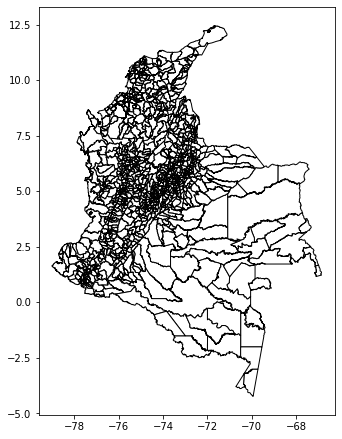

In [57]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
municipalities.plot(ax=ax, color='w', edgecolor='k')

**Dissolve geometries into country**

In [86]:
colombia = municipalities.dissolve()
colombia = colombia[['nombre_ent', 'geometry']]
colombia['nombre_ent'] = 'COLOMBIA'
colombia

,nombre_ent,geometry
0,COLOMBIA,"POLYGON ((-76.64844 0.25235, -76.64994 0.25092..."


**Save as GeoJSON**

In [88]:
municipalities.to_file('../../datasets/processed/municipalities.geojson', driver='GeoJSON') 
colombia.to_file('../../datasets/processed/colombia.geojson', driver='GeoJSON') 

### HeCo Mosaics
**Read data**

In [59]:
mosaics = gpd.read_file(f'../../datasets/raw/Meta_3_HeCO_Mc_Shapefiles/Meta_3_HeCo_Mosaicos_Consevación.shp')
mosaics.columns= mosaics.columns.str.lower()
mosaics.head()

,area_ha,mosaico,codmos,meta,geometry
0,2.571763e+06,Cordillera Oriental,COR,Meta 3,"POLYGON Z ((307611.365 248282.193 0.000, 30766..."
1,1.926857e+06,Piedemonte Amazónico - Macizo,PAM,Meta 3,"POLYGON Z ((72784.158 -602267.713 0.000, 73694..."
2,2.015930e+06,Transición Pacífico - Caribe,TPC,Meta 3,"POLYGON Z ((-44233.018 315066.261 0.000, -4413..."
3,3.254027e+06,Transición Orinoquía,TOR,Meta 3,"POLYGON Z ((260578.924 -103998.653 0.000, 2605..."
4,1.666095e+06,Cordillera Central,CCE,Meta 3,"POLYGON Z ((33990.039 -87114.991 0.000, 35379...."


Change projection

In [60]:
mosaics.crs

<Derived Projected CRS: PROJCS["Lambert_Azimutal_Colombia",GEOGCS["WGS 84" ...>
Name: Lambert_Azimutal_Colombia
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
mosaics = mosaics.to_crs("EPSG:4326")
mosaics.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Display geometries**

<AxesSubplot:>

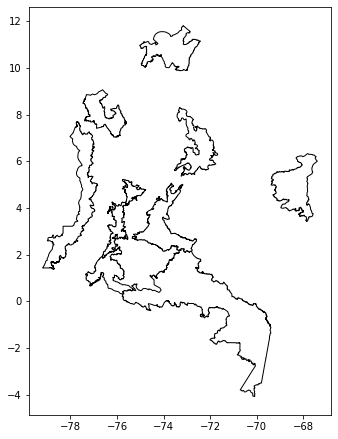

In [62]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
mosaics.plot(ax=ax, color='w', edgecolor='k')

**Save as GeoJSON**

In [63]:
mosaics.to_file('../../datasets/processed/mosaics.geojson', driver='GeoJSON') 

### Hydrological basins
**Read data**

In [213]:
basins = gpd.read_file(f'../../datasets/raw/hydrobasins_southam/hydrobasins_southam.shp')
basins.head(1)

,SUB_BAS,TO_BAS,MAJ_BAS,MAJ_NAME,SUB_NAME,SUB_AREA,MAJ_AREA,LEGEND,geometry
0,1003,-999,3001,Caribbean Coast,Altrato 1,5787,317043,1,"POLYGON ((-76.95000 8.12917, -76.95000 8.12500..."


**Intersect with country**

In [214]:
geometry = colombia['geometry'].iloc[0]
sindex = basins.sindex
# basins intersect with Colombia
possible_matches_index = list(sindex.intersection(geometry.bounds))
basins = basins.iloc[possible_matches_index]
# intersection between the basins and Colombia
new_geometries = basins.intersection(geometry)
basins['geometry'] = new_geometries
basins = basins.reset_index(drop=True).copy()
basins.head(1)

,SUB_BAS,TO_BAS,MAJ_BAS,MAJ_NAME,SUB_NAME,SUB_AREA,MAJ_AREA,LEGEND,geometry
0,3044,3042,3003,Orinoco,Guaviare 1,13346,974772,3,"POLYGON ((-70.34167 4.07083, -70.33750 4.07083..."


Remove Palmar sub-basin

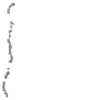

In [217]:
basins[(basins['MAJ_BAS'] == 3001) & (basins['SUB_BAS'] == 1012)]['geometry'].iloc[0]

In [233]:
basins = basins.drop(basins[(basins['MAJ_BAS'] == 3001) & (basins['SUB_BAS'] == 1012)].index[0])

Remove duplicates

In [236]:
duplicates = list(basins[basins.duplicated(subset=['MAJ_BAS', 'SUB_BAS'])]['SUB_NAME'].unique())
print(duplicates)

['Pueblo Viejo', 'Capatarida', 'Lesser Antilles', 'Bahia de Panama Coast', 'Archipielago de San Blas Coast', 'Colombia West Caribbean Sea Coast']


In [237]:
basins = pd.concat([basins[~basins['SUB_NAME'].isin(duplicates)], 
                   basins[basins['SUB_NAME'] == duplicates[4]].iloc[:1],
                   basins[basins['SUB_NAME'] == duplicates[5]].iloc[:1]])

Remove empty polygons

In [238]:
basins = basins[~basins['geometry'].is_empty]
basins = basins.sort_values(['MAJ_BAS', 'SUB_BAS']).reset_index(drop=True)
basins.columns = basins.columns.str.lower()
basins.head()

,sub_bas,to_bas,maj_bas,maj_name,sub_name,sub_area,maj_area,legend,geometry
0,1002,-999,3001,Caribbean Coast,Archipielago de San Blas Coast,5305,317043,1,"MULTIPOLYGON (((-77.07500 8.32035, -77.07529 8..."
1,1003,-999,3001,Caribbean Coast,Altrato 1,5787,317043,1,"POLYGON ((-76.94583 8.10833, -76.94167 8.10833..."
2,1004,1003,3001,Caribbean Coast,Sucio,4933,317043,1,"POLYGON ((-77.10417 7.42083, -77.10000 7.42083..."
3,1005,1003,3001,Caribbean Coast,Altrato 2,25125,317043,1,"POLYGON ((-77.58333 7.17083, -77.58333 7.17500..."
4,1006,-999,3001,Caribbean Coast,Golfo del Darien Coast,9119,317043,1,"MULTIPOLYGON (((-76.76250 7.91250, -76.76250 7..."


**Display geometries**

<AxesSubplot:>

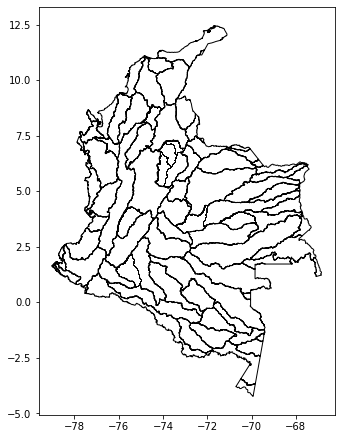

In [239]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
basins.plot(ax=ax, color='w', edgecolor='k')

**Save as GeoJSON**

In [240]:
basins.to_file('../../datasets/processed/basins.geojson', driver='GeoJSON') 

## Parameter definition
We set all relevant parameters for our notebook. 

**Put all vector data together** 

In [241]:
gdf_vectors = {"municipalities": municipalities,
    "mosaics": mosaics,
    "basins": basins}

# Data processing
## Zonal statistics
We convert raster data into vector by taking the mean value of each indicator at every geometry.
### Rasterize vector data
**Create the data mask by rasterizing the vector data**

In [242]:
da_mask = {}
ids_not_in_mask = {}
for gdf_name, gdf in gdf_vectors.items():
    print(gdf_name)
    #Create the data mask by rasterizing the vector data
    gdf = gdf.reset_index(drop=True).copy()
    da_mask[gdf_name], ids_not_in_mask[gdf_name] = create_ds_mask(gdf.copy(), ds, name=gdf_name.lower().replace(' ', '_'), lon_name='x', lat_name='y')

municipalities
Number of indexes: 1121
Number of geoms: 1121


/opt/conda/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Number of ints in mask: 1121
mosaics
Number of indexes: 9
Number of geoms: 9
Number of ints in mask: 9
basins
Number of indexes: 83
Number of geoms: 83


/opt/conda/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Number of ints in mask: 83


**Display masks**

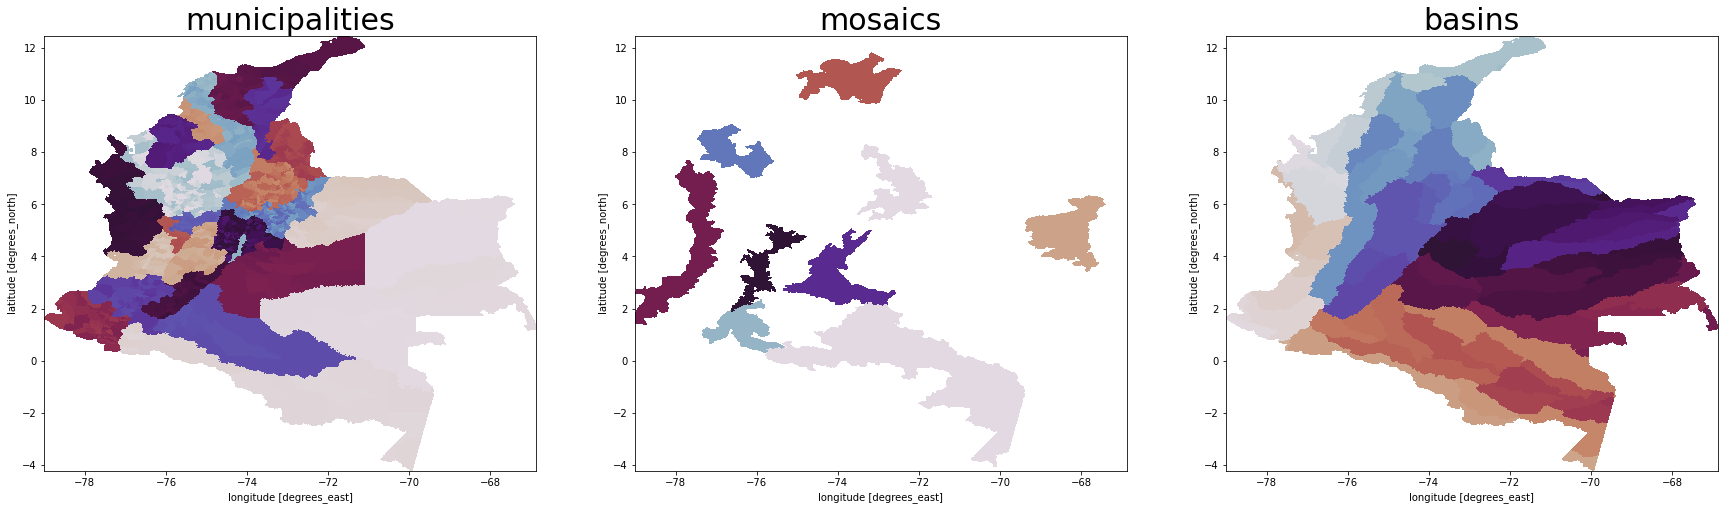

In [250]:
fig, axs = plt.subplots(1, 3, figsize=(30,8))

n=0
for geo_name, mask in da_mask.items():
    mask.plot.pcolormesh(ax=axs[n], cmap='twilight', x='x', y='y', add_colorbar=False)
    axs[n].set_title(geo_name, fontsize=30);
    n+=1 